# Analiza vzrokov prometnih nesreč v Sloveniji
S to analizo sva želela pokazati glavne razloge/faktorje za prometne nesreče v Sloveniji.

## Člana
* Nermin Mujagić
* Jaša Jovan

## Opis podatkov
Za projektno nalogo sva zbrala podatke na spletni strani podatki.gov.si, kjer sva vzela [podatke o prometnih nesrečah od leta 2009 pa do leta 2019](https://podatki.gov.si/dataset/mnzpprometne-nesrece-od-leta-2009-dalje). Datoteke so med seboj ločene po letih.

## Cilji
- starost udeleženca / vozniški staž
- delež alkohola v krvi
- vpliv dela prostih praznikov
- vpliv letnih casov
- starostne skupine

## Rezultati

# Imports

In [26]:
from csv import DictReader
import numpy as np
import chardet
import matplotlib
from scipy import stats
import collections
from datetime import datetime

import matplotlib.pyplot as plt

# Vnos podatkov

In [53]:
reader = DictReader(open('data/pn2019.csv','rt', encoding='Windows-1252'),delimiter=';')
podatki19 = np.array([[row['KlasifikacijaNesrece'], row['VrednostAlkotesta'], row['VozniskiStazVLetih'], row['UraPN'], row['DatumPN'], row['Spol'], row['Starost']] for row in reader])

# Popravki, dodajanje

In [55]:
# popravljaje alkotest vrednosti
for i in range(len(podatki19)):
    podatki19[i][1] = float(podatki19[i][1].replace(',','.'))
    
# dobimo samo uro
ure = [[ura.split(".")[0]] for ura in podatki19[:, 3]]
podatki19 = np.append(podatki19, ure, axis=1)

# dodajanje datetimes
datetimes = []
for row in podatki19:
    ura, minute = row[3].split(".")
    dan, mesec, leto = row[4].split(".")
    
    datetimes.append([datetime(int(leto), int(mesec), int(dan), int(ura), int(minute))])
    
podatki19 = np.append(podatki19, datetimes, axis=1)
    

# dodajanje dnevov iz datuma
dnevi = [[datetime.strptime(d, "%d.%m.%Y").strftime('%A')] for d in podatki19[:, 4]]

podatki19 = np.append(podatki19, dnevi, axis=1)

# starostne skupine
# mladi -> 16-24
# odrasli -> 25-64
# starejsi -> 64<
star_skupine = []
for row in podatki19:
    starost = int(row[6])
    if starost >= 16 and starost <= 24:
        star_skupine.append(["1"])
    elif starost >= 25 and starost <= 64:
        star_skupine.append(["2"])
    elif starost >= 65:
        star_skupine.append(["3"])
    else:
        star_skupine.append(["-1"])
        
podatki19 = np.append(podatki19, star_skupine, axis=1)

# letni casi
letni_casi = []

for d in podatki19[:, 8]:
    t_leto = d.year
    if d >= datetime(t_leto, 3, 21) and d <= datetime(t_leto, 6, 21): # pomlad
        letni_casi.append(["1"])
        
    elif d > datetime(t_leto, 6, 21) and d <= datetime(t_leto, 9, 23): # poletje
        letni_casi.append(["2"])
    
    elif d > datetime(t_leto, 9, 23) and d <= datetime(t_leto, 12, 21): # jesen
        letni_casi.append(["3"])
    
    else: # zima
        letni_casi.append(["4"])

podatki19 = np.append(podatki19, letni_casi, axis=1)

# Porazdelitev klasifikacij nesrec

<BarContainer object of 4 artists>

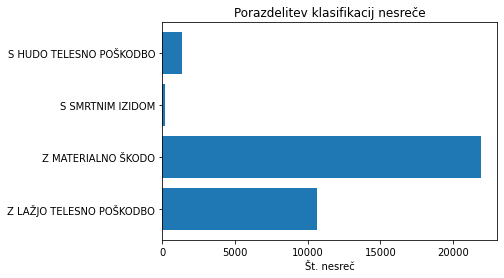

In [29]:
vrste = dict()
for poskodba in podatki19[:, 0]:
    if(poskodba not in vrste):
        vrste[poskodba] = 1
    else:
        vrste[poskodba] += 1

xVal = list(vrste.values())
yVal = list(vrste.keys())

plt.title("Porazdelitev klasifikacij nesreče")
plt.xlabel("Št. nesreč")
plt.barh(yVal,xVal)

Največ izidov nesreč je le z materialno škodo, kar je tudi pričakovano, saj je manjša verjetnost poškodbe pri nesrečah, kot je le škoda na avtomobilu ali okolici. Najmanj je srmtnih izidov.

# Delež voznikov pod in nad dovoljeno mejo.

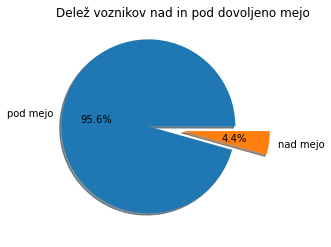

In [30]:
alkotest = np.array([float(value) for value in podatki19[:,1]])
meja = 0.24

podMeja = alkotest[alkotest[:] < meja]
nadMeja = alkotest[alkotest[:] >= meja]

# Delež voznikov, ki so napihali nad dovoljeno mejo je le 4.4%
len(nadMeja) / len(alkotest)

labels = 'pod mejo', 'nad mejo'
sizes = [len(podMeja), len(nadMeja)]

plt.title("Delež voznikov nad in pod dovoljeno mejo")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=(0.4,0))
plt.show()

Najbolj zanimiv podatek za naju je bil, da je le 4.4% voznikov imelo prekomerno vsebino alkohola pri alkotestu (vpihu). Pričakovala sva, da bo to večji delež. Verjetno se bo izkazalo, da bo korelacija precej močna.

# Nesrece vozniski staz

DescribeResult(nobs=34161, minmax=(0, 73), mean=15.719797429817628, variance=241.8832523711421, skewness=0.7504461149901434, kurtosis=-0.4380028243977163)


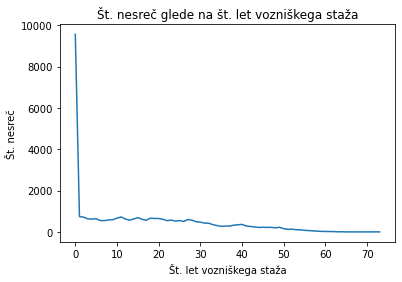

In [31]:
vozniskiStaz = np.array([int(value) for value in podatki19[:,2]])
stazNesrece = collections.Counter(vozniskiStaz)

print(stats.describe(vozniskiStaz))

stazNesrece = collections.OrderedDict(sorted(stazNesrece.items()))

keys = list(stazNesrece.keys())
values = list(stazNesrece.values())

plt.title('Št. nesreč glede na št. let vozniškega staža')
plt.ylabel('Št. nesreč')
plt.xlabel('Št. let vozniškega staža')
plt.plot(keys,values)

Zelo očitno da je največ nesreč pri vozniškemu stažu do 1 leta. Trend je takšen, da z več leti staža, manjša se št. nesreč. Vredno je tudi omeniti, da seveda ker so podatki od 2009 - 2019, je seveda največ zabeleženo o tistih, ki imajo 10 let staž ali manj. Povprecno stevilo vozniškega staza je 15.7 let.

# Nesreče ponoči
### Nesrece ponoci

In [32]:
# Nesrece ponoci 23h -> 4h
nesrece_ponoci = podatki19[(podatki19[:, 6].astype(int) < 5) | (podatki19[:, 6].astype(int) > 22)]

# Delez nesrec ponoci
len(nesrece_ponoci) / len(podatki19)

0.8903135154123123

### Delez prekomerno vinjenih ponoci

In [33]:
alkotestPonoci = np.array([float(value) for value in podatki19[:,1]])
nadMejaPonoci = alkotestPonoci[alkotestPonoci[:] >= meja]
len(nadMejaPonoci) / len(nesrece_ponoci)

0.0490234760307753

Priblizno 5% nesrec se zgodi ponoci. Od tega je kar 85% voznikov prekomerno vinjenih ponoci.

# Kolicina popitega skozi teden

Ponedeljek 0.02176056338028169 5538
Torek 0.022250409165302795 4888
Sreda 0.02541468064823643 5245
Cetrtek 0.02175289575289576 5180
Petek 0.034535616217089345 6191
Sobota 0.05348583877995643 4131
Nedelja 0.05346050870147257 2988


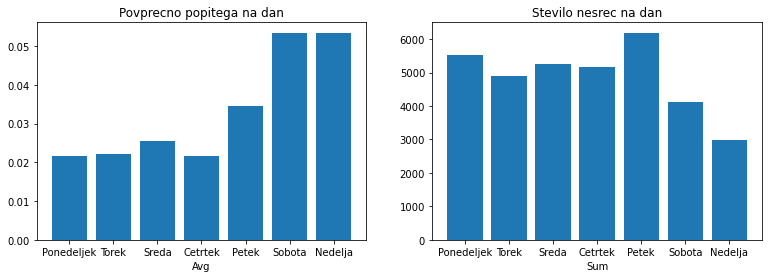

In [70]:
labels = ["Ponedeljek", "Torek", "Sreda", "Cetrtek", "Petek", "Sobota", "Nedelja"]

ponedeljek = podatki19[podatki19[:, 9] == "Monday", 1]
torek = podatki19[podatki19[:, 9] == "Tuesday", 1]
sreda = podatki19[podatki19[:, 9] == "Wednesday", 1]
cetrtek = podatki19[podatki19[:, 9] == "Thursday", 1]
petek = podatki19[podatki19[:, 9] == "Friday", 1]
sobota = podatki19[podatki19[:, 9] == "Saturday", 1]
nedelja = podatki19[podatki19[:, 9] == "Sunday", 1]

avg_ponedeljek = sum(ponedeljek.astype(float)) / len(ponedeljek)
avg_torek = sum(torek.astype(float)) / len(torek)
avg_sreda = sum(sreda.astype(float)) / len(sreda)
avg_cetrtek = sum(cetrtek.astype(float)) / len(cetrtek)
avg_petek = sum(petek.astype(float)) / len(petek)
avg_sobota = sum(sobota.astype(float)) / len(sobota)
avg_nedelja = sum(nedelja.astype(float)) / len(nedelja)

x_povp = [avg_ponedeljek, avg_torek, avg_sreda, avg_cetrtek, avg_petek, avg_sobota, avg_nedelja]
x_sum = [len(ponedeljek), len(torek), len(sreda), len(cetrtek), len(petek), len(sobota), len(nedelja)]

print("Ponedeljek", avg_ponedeljek, len(ponedeljek))
print("Torek", avg_torek, len(torek))
print("Sreda", avg_sreda, len(sreda))
print("Cetrtek", avg_cetrtek, len(cetrtek))
print("Petek", avg_petek, len(petek))
print("Sobota", avg_sobota, len(sobota))
print("Nedelja", avg_nedelja, len(nedelja))


figure, axis = plt.subplots(1, 2, figsize=(13, 4))
  
axis[0].bar(labels, x_povp)
axis[0].set_title("Povprecno popitega na dan")
axis[0].set_xlabel("Avg")
  
axis[1].bar(labels, x_sum)
axis[1].set_title("Stevilo nesrec na dan")
axis[1].set_xlabel("Sum")

plt.show()

Vidi se da skozi teden ljude manj pijejo, opazi se pa, da ze v petek je manjsi skok in potem se vecji za cez vikend. Cez vikend se vidi upad kolicina nesrec, verjetno, ker so ljudje bolj doma, skozi teden se pa vozijo v in iz sluzbe. Vidi se manjsi skok v petek, ker se po vsej verjetnosti vsem mudi domov.

# Kolicina popitega po dela prostih praznikih

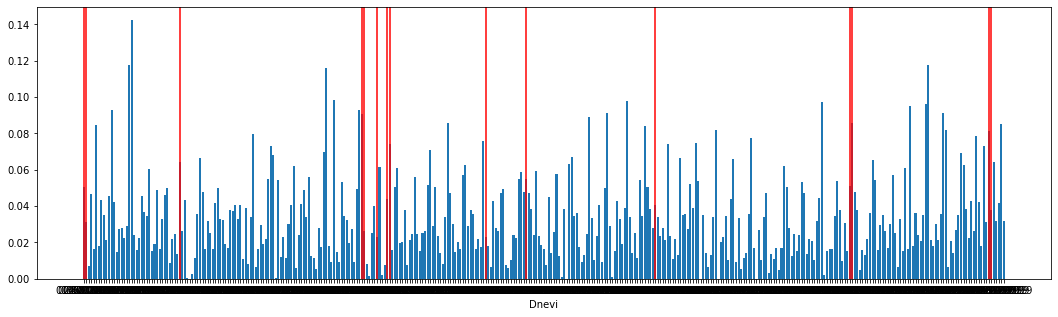

In [28]:
sorted_podatki19 = podatki19[np.argsort(podatki19[:, 7])]

sorted_podatki19_dict = dict()
for row in sorted_podatki19:
    datum = row[4]
    
    if datum not in sorted_podatki19_dict:
        rez = sorted_podatki19[sorted_podatki19[:, 4] == datum, 1]
        sorted_podatki19_dict[datum] = sum(rez.astype(float)) / len(rez)
        
labels = list(sorted_podatki19_dict.keys())
x = list(sorted_podatki19_dict.values())

dela_prosti_dnevi2019 = ["01.01.2019", "02.01.2019", "08.02.2019", "21.04.2019", "22.04.2019", "27.04.2019", 
                     "01.05.2019", "02.05.2019", "09.06.2019", "25.06.2019", "15.08.2019", "31.10.2019",
                    "01.11.2019", "25.12.2019", "26.12.2019"]

plt.figure(figsize=(40, 5))
plt.subplot(1, 2, 1)
plt.bar(labels, x)
plt.xlabel("Dnevi")

for d in dela_prosti_dnevi2019:
    plt.axvline(x=d, color='r', label=d)

In [31]:
print("02.01.2019", sorted_podatki19_dict["02.01.2019"])
print("03.01.2019", sorted_podatki19_dict["03.01.2019"])
print("Razlika:", sorted_podatki19_dict["03.01.2019"] - sorted_podatki19_dict["02.01.2019"])
print("----------------")

print("08.02.2019", sorted_podatki19_dict["08.02.2019"])
print("09.02.2019", sorted_podatki19_dict["09.02.2019"])
print("Razlika:", sorted_podatki19_dict["09.02.2019"] - sorted_podatki19_dict["08.02.2019"])
print("----------------")

print("21.04.2019", sorted_podatki19_dict["21.04.2019"])
print("22.04.2019", sorted_podatki19_dict["22.04.2019"])
print("Razlika:", sorted_podatki19_dict["22.04.2019"] - sorted_podatki19_dict["21.04.2019"])
print("----------------")

print("27.04.2019", sorted_podatki19_dict["27.04.2019"])
print("28.04.2019", sorted_podatki19_dict["28.04.2019"])
print("Razlika:", sorted_podatki19_dict["28.04.2019"] - sorted_podatki19_dict["27.04.2019"])
print("----------------")

print("02.05.2019", sorted_podatki19_dict["02.05.2019"])
print("03.05.2019", sorted_podatki19_dict["03.05.2019"])
print("Razlika:", sorted_podatki19_dict["03.05.2019"] - sorted_podatki19_dict["02.05.2019"])
print("----------------")

02.01.2019 0.03125
03.01.2019 0.00676923076923077
Razlika: -0.02448076923076923
----------------
08.02.2019 0.06426229508196721
09.02.2019 0.026515151515151516
Razlika: -0.03774714356681569
----------------
21.04.2019 0.09046153846153845
22.04.2019 0.026385542168674697
Razlika: -0.06407599629286376
----------------
27.04.2019 0.022794117647058826
28.04.2019 0.061290322580645165
Razlika: 0.03849620493358634
----------------
02.05.2019 0.07400000000000001
03.05.2019 0.01574074074074074
Razlika: -0.058259259259259275
----------------


Iz spodnjih rezulatov kaze, da dela prosti prazniki ne vplivajo na vinjenost voznikov. Tezko je reci ali zato, ker
praznike prezivijo doma in se ne vozijo ali pa ker ne popijejo vec kot ob drugih dnevih.

# Nesrece po urah

In [15]:
podatki19[:, 5]
ura_avg_dict = dict()
ura_sum_dict = dict()

for row in podatki19:
    ura = row[5]
    rez = podatki19[podatki19[:, 5] == ura, 1].astype(float)
    if ura not in ura_avg_dict:
        ura_avg_dict[ura] = sum(rez) / len(rez)
        ura_sum_dict[ura] = len(rez)

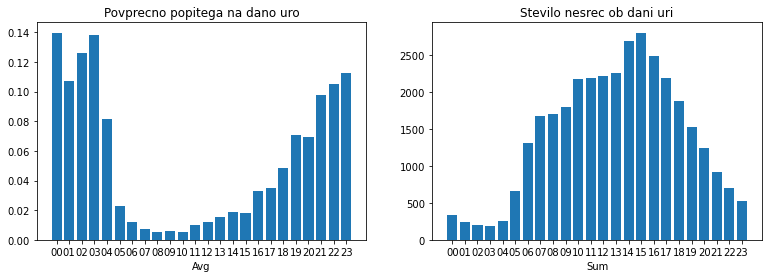

In [16]:
ura_avg_dict = dict(sorted(ura_avg_dict.items()))

ura_sum_dict = dict(sorted(ura_sum_dict.items()))

labelsAvg = list(ura_avg_dict.keys())
xAvg = list(ura_avg_dict.values())

labelsSum = list(ura_sum_dict.keys())
xSum = list(ura_sum_dict.values())

figure, axis = plt.subplots(1, 2, figsize=(13, 4))
  
axis[0].bar(labelsAvg, xAvg)
axis[0].set_title("Povprecno popitega ob dani uri")
axis[0].set_xlabel("Avg")
  
axis[1].bar(labelsSum, xSum)
axis[1].set_title("Stevilo nesrec ob dani uri")
axis[1].set_xlabel("Sum")

plt.show()

Kot se vidi iz spodnjih grafov se kolicinsko zgodi vec nesrec podnevi, vendar ponoci so vozniki bolj vinjeni. Grafa sta si skoraj inverzna.

# Moski vs zenske

In [41]:
nesrece_moski = podatki19[podatki19[:, 5] == "MOŠKI"]
len(nesrece_moski) / len(podatki19)

0.678258833172331

Moski so odgovorni za priblizno 67% nesrec. To se bo tudi videlo v spodnjem razdelku.

# Skupna povprecna vinjenost

In [19]:
sum(podatki19[:, 1].astype(float)) / len(podatki19)

0.03131494979655157

# Nesrece glede na starostne skupine

In [16]:
mladi = podatki19[podatki19[:, 10] == "1"]
odrasli = podatki19[podatki19[:, 10] == "2"]
starejsi = podatki19[podatki19[:, 10] == "3"]
drugo = podatki19[podatki19[:, 10] == "-1"]

mladi_avg_vinj = sum(mladi[:, 1].astype(float)) / len(mladi)
odrasli_avg_vinj = sum(odrasli[:, 1].astype(float)) / len(odrasli)
starejsi_avg_vinj = sum(starejsi[:, 1].astype(float)) / len(starejsi)
drugo_avg_vinj = sum(drugo[:, 1].astype(float)) / len(drugo)

mladi_moski = len(mladi[mladi[:, 5] == "MOŠKI"])
odrasli_moski = len(odrasli[odrasli[:, 5] == "MOŠKI"])
starejsi_moski = len(starejsi[starejsi[:, 5] == "MOŠKI"])
drugo_moski = len(drugo[drugo[:, 5] == "MOŠKI"])

print("Mladi")
print("Stevilo nesrec:", len(mladi))
print("Povprecna vinjenost:", mladi_avg_vinj)
print("Delez moskih:", mladi_moski / len(mladi))
print("Delez nesrec:", len(mladi) / len(podatki19))
print("--------------------")

print("Srednji")
print("Stevilo nesrec:", len(odrasli))
print("Povprecna vinjenost:", odrasli_avg_vinj)
print("Delez moskih:", odrasli_moski / len(odrasli))
print("Delez nesrec:", len(odrasli) / len(podatki19))
print("--------------------")

print("Stari")
print("Stevilo nesrec:", len(starejsi))
print("Povprecna vinjenost:", starejsi_avg_vinj)
print("Delez moskih:", starejsi_moski / len(starejsi))
print("Delez nesrec:", len(starejsi) / len(podatki19))
print("--------------------")

print("Drugo")
print("Stevilo nesrec:", len(drugo))
print("Povprecna vinjenost:", drugo_avg_vinj)
print("Delez moskih:", drugo_moski / len(drugo))
print("Delez nesrec:", len(drugo) / len(podatki19))
print("--------------------")

Mladi
Stevilo nesrec: 4563
Povprecna vinjenost: 0.025768134998904228
Delez moskih: 0.6846373000219154
Delez nesrec: 0.13357337314481427
--------------------
Srednji
Stevilo nesrec: 24366
Povprecna vinjenost: 0.03466428630058271
Delez moskih: 0.6769679060986621
Delez nesrec: 0.7132695178712567
--------------------
Stari
Stevilo nesrec: 4565
Povprecna vinjenost: 0.023518072289156627
Delez moskih: 0.6893756845564074
Delez nesrec: 0.13363191944029743
--------------------
Drugo
Stevilo nesrec: 667
Povprecna vinjenost: 0.00026986506746626683
Delez moskih: 0.6056971514242878
Delez nesrec: 0.019525189543631628
--------------------


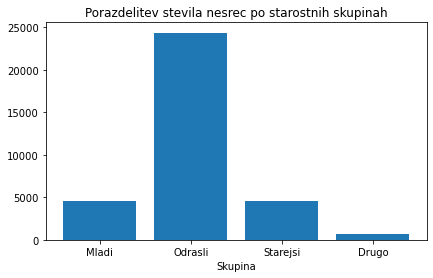

In [17]:
labels = ["Mladi", "Odrasli", "Starejsi", "Drugo"]
x = [len(mladi), len(odrasli), len(starejsi), len(drugo)]

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.bar(labels, x)
plt.title("Porazdelitev stevila nesrec po starostnih skupinah")
plt.xlabel("Skupina")
plt.show()

Vidi se, da starostna skupina odrasli zagresijo najvec nesrec in so tudi v povprecju najbolj vinjeni. To je verjetno, ker jih ima vecina sluzbo in se iz nje vracajo ob casih, kjer so nesrece najbolj pogoste. Za najvecjo vinjenost pa poskrbijo gredo po sluzbi se kaj spiti in potem sele domov.
Pri vseh starostnih skupinah se pa vidi, da moski konstantno zagresijo okoli 67% nesrec.

# Letni casi

In [71]:
pomlad = podatki19[podatki19[:, 15] == "1"]
poletje = podatki19[podatki19[:, 15] == "2"]
jesen = podatki19[podatki19[:, 15] == "3"]
zima = podatki19[podatki19[:, 15] == "4"]

print("Pomlad")
print("Stevilo nesrec:", len(pomlad))
print("Povprecna vinjenost:", sum(pomlad[:, 1].astype(float)) / len(pomlad))
print("----------------")

print("Poletje")
print("Stevilo nesrec:", len(poletje))
print("Povprecna vinjenost:", sum(poletje[:, 1].astype(float)) / len(poletje))
print("----------------")

print("Jesen")
print("Stevilo nesrec:", len(jesen))
print("Povprecna vinjenost:", sum(jesen[:, 1].astype(float)) / len(jesen))
print("----------------")

print("Zima")
print("Stevilo nesrec:", len(zima))
print("Povprecna vinjenost:", sum(zima[:, 1].astype(float)) / len(zima))


Pomlad
Stevilo nesrec: 8693
Povprecna vinjenost: 0.031049119981594344
----------------
Poletje
Stevilo nesrec: 9106
Povprecna vinjenost: 0.03148034263123218
----------------
Jesen
Stevilo nesrec: 9328
Povprecna vinjenost: 0.029775943396226422
----------------
Zima
Stevilo nesrec: 7034
Povprecna vinjenost: 0.03347028717657094


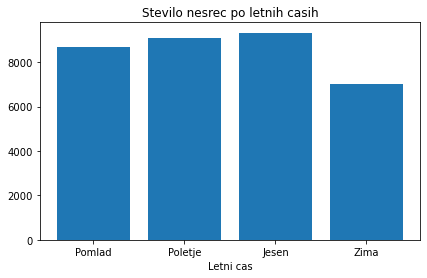

In [69]:
labels = ["Pomlad", "Poletje", "Jesen", "Zima"]
x = [len(pomlad), len(poletje), len(jesen), len(zima)]

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.bar(labels, x)
plt.title("Stevilo nesrec po letnih casih")
plt.xlabel("Letni cas")
plt.show()

Pomladi, poleti in jeseni si je stevilo nesrec podobno, pozimi se vidi upadec stevila nesrec. Povprecna vinjenost je v vseh letnih casih priblizno ista, kar kaze, da letni casi ne vplivajo toliko na kolicino popitega.

# Zaključek
Po najinem mnenju je tezko sklepati o alkoholiziranosti splosne populacije saj ne vemo koliko ljudi pije doma ali pa se v enem avtu vozi vec vinjenih oseb. Zna biti pa dober indikator za navade splosne populacije, v smislu ob katerih casih najvec pijejo. Pri preverjanju dela prostih praznikov nisva nasla nekega prirastka vinjenosti ali stevila nesrec. Pri preverjanju letnih casov se vinjenost nic ne dvigne in stevilo nesrec je za pomlad, poletje, jesen priblizno isto, vendar se vidi upad v zimskem casu, verjetno, ker se ljudje zadrzavajo bolj doma na toplem kot da bi sli ven na pijaco.